# Project 1 (Due Nov 13)

The goal of the first project is to non-parametrically model some phenomenon of interest, and generate sequences of values. There are six options below:

- Chordonomicon: 680,000 chord progressions of popular music songs. Create a chord generator, similar to what we did with Bach in class, but for a particular artist or genre. (https://github.com/spyroskantarelis/chordonomicon)
- Financial Time series, S&P500 Stocks: There are 500 time series here. Model how individual time series adjust over time, either together or separately. (https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks)
- MIT-BIT Arrythmia Database: Arrythmia is an abnormal heart rhythm. This is a classic dataset that a day of ECG time series measurements for 4,000 patients. (https://www.physionet.org/content/mitdb/1.0.0/)
- Ukraine conflict monitor: The ACLED Ukraine Conflict Monitor provides near real-time information on the ongoing war in Ukraine, including an interactive map, a curated data file, and weekly situation updates Ukraine Conflict Monitor, maintained by the Armed Conflict Location & Event Data Project, starting in 2022, including battles, explosions/remote violence, violence against civilians, protests, and riots: https://acleddata.com/monitor/ukraine-conflict-monitor
SIPRI Arms Trade: The SIPRI Arms Transfers Database is a comprehensive public resource tracking all international transfers of major conventional arms from 1950 to the present. For each deal, information includes: number ordered, supplier/recipient identities, weapon types, delivery dates, and deal comments. The database can address questions about: who are suppliers and recipients of major weapons, what weapons have been transferred by specific countries, and how supplier-recipient relationships have changed over time. https://www.sipri.org/databases/armstransfers
- Environmental Protection Agency data: The EPA, in general, has excellent data on the release of toxic substances, and I also tracked down air quality and asthma. You can put these together to look at how changes in toxic release correlate with air quality and respiratory disease over time: https://www.epa.gov/data https://www.epa.gov/toxics-release-inventory-tri-program/tri-toolbox https://www.cdc.gov/asthma/most_recent_national_asthma_data.htm https://www.earthdata.nasa.gov/topics/atmosphere/air-quality/data-access-tools

If you have other data sources that you're interested in, I am willing to consider them, as long as they lend themselves to an interesting analysis.

Submit a document or notebook that clearly addresses the following:

1. Describe the data clearly -- particularly any missing data that might impact your analysis -- and the provenance of your dataset. Who collected the data and why? (10/100 pts)
2. What phenomenon are you modeling? Provide a brief background on the topic, including definitions and details that are relevant to your analysis. Clearly describe its main features, and support those claims with data where appropriate. (10/100 pts)
3. Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts)
4. Either use your model to create new sequences (if the model is more generative) or bootstrap a quantity of interest (if the model is more inferential). (15/100 pts)
5. Critically evaluate your work in part 4. Do your sequences have the properties of the training data, and if not, why not? Are your estimates credible and reliable, or is there substantial uncertainty in your results? (15/100 pts)
6. Write a conclusion that explains the limitations of your analysis and potential for future work on this topic. (10/100 pts)

In addition, submit a GitHub repo containing your code and a description of how to obtain the original data from the source. Make sure the code is commented, where appropriate. Include a .gitignore file. We will look at your commit history briefly to determine whether everyone in the group contributed. (10/100 pts)

In class, we'll briefly do presentations and criticize each other's work, and participation in your group's presentation and constructively critiquing the other groups' presentations accounts for the remaining 15/100 pts.

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [177]:
url = "https://huggingface.co/datasets/ailsntua/Chordonomicon/resolve/main/chordonomicon_v2.csv"
df = pd.read_csv(url, dtype=str, low_memory=False)

In [178]:
df.head()

,id,chords,release_date,genres,decade,rock_genre,artist_id,main_genre,spotify_song_id,spotify_artist_id
0,1,<intro_1> C <verse_1> F C E7 Amin C F C G7 C F...,NaN,'classic country pop',NaN,NaN,artist_1,pop,NaN,4AIEGdwDzPELXYgM5JaEY5
1,2,<intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs...,2003-01-01,'alternative metal' 'alternative rock' 'nu met...,2000.0,pop rock,artist_2,metal,2ffJZ2r8HxI5DHcmf3BO6c,694QW15WkebjcrWgQHzRYF
2,3,<intro_1> Csmin <verse_1> A Csmin A Csmin A Cs...,2003-01-01,'alternative metal' 'canadian rock' 'funk meta...,2000.0,canadian rock,artist_3,metal,5KiY8SZEnvCPyIEkFGRR3y,0niJkG4tKkne3zwr7I8n9n
3,4,<intro_1> D Dmaj7 D Dmaj7 <verse_1> Emin A D G...,2022-09-23,NaN,2020.0,NaN,artist_4,NaN,01TtAcUqyLCRBZq4ZZiQWS,17BfKBemmMGO5ZAK25wraW
4,5,<intro_1> C <verse_1> G C G C <chorus_1> F Dmi...,2023-02-10,'modern country pop',2020.0,NaN,artist_5,pop,3zUecdrWC3IqrNSjhnoF3G,4GGfAshSkqoxpZdoaHm7ky


In [179]:
df_country = df[df['main_genre'].str.lower() == 'country']

print(df_country.shape)
print(df_country['main_genre'].value_counts())


(53306, 10)
main_genre
country    53306
Name: count, dtype: int64


In [180]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53306 entries, 20 to 642859
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 53306 non-null  object
 1   chords             53306 non-null  object
 2   release_date       44962 non-null  object
 3   genres             53306 non-null  object
 4   decade             44962 non-null  object
 5   rock_genre         15083 non-null  object
 6   artist_id          53306 non-null  object
 7   main_genre         53306 non-null  object
 8   spotify_song_id    47247 non-null  object
 9   spotify_artist_id  53306 non-null  object
dtypes: object(10)
memory usage: 4.5+ MB


In [194]:
df_country.isna().sum()

id                       0
chords                   0
release_date          8344
genres                   0
decade                8344
rock_genre           38223
artist_id                0
main_genre               0
spotify_song_id       6059
spotify_artist_id        0
dtype: int64

## Question 1: Missing Data, Provenance, and Purpose

Our dataset is a filtered subset of the Chordonomicon collection, which contains over 680,000 chord progressions from popular songs. We’ve focused on the 53,306 songs that are categorized under the “country” genre. The full Chordonomicon dataset is resource for studying chord progressions in contemporary popular music and is often used in research related to music analysis and chord progression modeling.

The dataset includes various pieces of information about each song, like identifiers, chord progressions, genre classifications, release dates, and artist details. But, there are some missing values in the dataset that are important to note because they could affect certain types of analysis.


- Release date and decade: Around 8,344 songs are missing a release date (and therefore the corresponding decade information). This could impact any analysis that looks at time-based trends—for example, understanding how musical styles or chord progressions have evolved over time might be difficult without this data.
- Rock genre: A large portion of the dataset (38,223 songs) has missing information about whether the song belongs to a rock sub-genre. This could make it challenging to explore detailed sub-genre analysis or identify hybrid genres that mix country and rock elements.
- Spotify song ID: About 5,000 songs are missing a Spotify song ID, which could limit any analysis that relies on external Spotify metadata, such as play counts, streaming trends, or cross-referencing song popularity with other platforms.

The Chordonomicon dataset was created by Spyridon Kantarelis et al. (2024). The goal of the project was to build a large-scale resource of chord progressions from popular music, providing valuable data for those studying musical structure and experimenting with AI-based music generation. Researchers and musicians can use this dataset to analyze patterns in how different genres use chords, explore genre-specific musical structures, or even generate new music that mimics real-world chord progressions. The dataset has been specifically designed for computational musicology, with applications in machine learning and music generation. Its large and diverse collection of chord progressions serves as a foundation for building models that can create new music or analyze the evolution of music across different eras and genres.

## Question 2: The Phenomenon Being Modeled

## Question 3

In [195]:
#filter to get just the country genre
countrydf = df.query("main_genre == 'country'")
countrydf.shape

(53306, 10)

In [197]:
#get a list of chords for each song, removing tags like <verse_1>
songs = countrydf['chords']
chord_lists = [[chord for chord in song.split() if '<' not in chord] for song in songs]
chord_lists[1]

['E',
 'D/E',
 'E',
 'D/E',
 'E',
 'A',
 'E',
 'A',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'B',
 'A',
 'E',
 'D/E',
 'A',
 'E',
 'D/E',
 'A',
 'E',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'A',
 'B',
 'E/Gs',
 'A',
 'B',
 'E/Gs',
 'A',
 'B',
 'E/Gs',
 'A',
 'B',
 'E/Gs',
 'A',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'E',
 'A',
 'B',
 'E',
 'B',
 'E',
 'B',
 'E',
 'B',
 'D/E',
 'A',
 'E',
 'B',
 'D',
 'E',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'A',
 'B',
 'A']

In [198]:
# tmp = chord_lists[1]
# for i in range(0, len(tmp)):
#     if '/' in tmp[i]:
#         # print(tmp[i])
#         # print(tmp[i].split('/')[0])
#         tmp[i] = tmp[i].split('/')[0]
#         print(tmp[i])
# tmp

for song in chord_lists:
    for i in range(0, len(song)):
        if '/' in song[i]:
            song[i] = song[i].split('/')[0]
        

In [199]:
#build state list
states = set()
for i in range(1, len(chord_lists)):
    song_i = set(chord_lists[i])
    states = states.union(song_i)
    
states = list(states)

In [201]:
# states.sort()
len(states)

468

In [202]:
S = len(states)
tr_counts = np.zeros( (S,S) )

#get transition counts
for song in chord_lists:
    seq = np.array(song)
    for t in range(1, len(seq)):
        #current and next tokens
        x_tml = seq[t-1] #previous state
        x_t = seq[t] #current state
        #determine transition indices
        index_from = states.index(x_tml)
        index_to = states.index(x_t)
        #update transition counts
        tr_counts[index_from, index_to] += 1

print('Transition Counts:\n', tr_counts)

Transition Counts:
 [[1. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [203]:
#get state proportions
sums = tr_counts.sum(axis=0, keepdims=True)
print('State Proportions:\n')
print(sums)

State Proportions:

[[2.82000e+03 6.50000e+01 3.70000e+01 1.30000e+02 2.00000e+00 7.40000e+01
  1.30000e+01 6.30000e+01 5.50000e+01 3.57400e+03 1.50600e+03 4.76000e+02
  6.00000e+00 2.00000e+00 2.70000e+01 1.25000e+02 1.25900e+03 3.47200e+03
  4.00000e+00 1.89720e+04 3.80000e+01 1.84400e+03 1.80000e+01 6.00000e+00
  6.00000e+00 2.40000e+01 5.40000e+02 4.00000e+00 2.30000e+01 3.50000e+01
  1.24410e+04 4.90000e+02 6.00000e+00 9.00000e+00 1.30000e+01 6.00000e+00
  3.27000e+02 5.59729e+05 1.00000e+00 5.10000e+01 2.99000e+02 1.44000e+02
  7.30000e+01 2.50000e+01 7.00000e+00 9.00000e+00 6.30000e+02 1.80000e+01
  6.97428e+05 2.00000e+00 6.30000e+01 8.00000e+00 4.00000e+00 1.35200e+03
  1.40000e+01 4.00000e+00 8.00000e+00 1.21700e+03 3.30000e+01 1.90000e+01
  1.03000e+02 1.10000e+01 1.00000e+00 9.34000e+02 1.00000e+00 6.70000e+01
  1.28100e+03 4.80000e+01 2.10000e+01 4.99400e+04 6.10000e+01 9.70000e+01
  1.58000e+02 1.29000e+02 1.85000e+02 1.16000e+02 1.00000e+00 4.70000e+01
  1.70000e+01 1.70

In [204]:
#normalize the transition count matrix to get proportions
tr_pr = np.divide(tr_counts, sums, out = np.zeros_like(tr_counts), where = sums!=0)

print('Transition Proportions:\n')
tr_df = pd.DataFrame(np.round(tr_pr, 2), columns = states, index = states)
print(tr_df)


Transition Proportions:

            Gmaj7  Fadd11  Gsdim7  Dmin9  Bbminadd11  Gsmaj7  Dsaugmaj7  \
Gmaj7         0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Fadd11        0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Gsdim7        0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Dmin9         0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Bbminadd11    0.0     0.0     0.0    0.0         0.0     0.0        0.0   
...           ...     ...     ...    ...         ...     ...        ...   
Cminadd9      0.0     0.0     0.0    0.0         0.0     0.0        0.0   
F9            0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Dminadd13     0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Db9           0.0     0.0     0.0    0.0         0.0     0.0        0.0   
Faug          0.0     0.0     0.0    0.0         0.0     0.0        0.0   

            Dsno3d  Dminmaj7   Fs7  ...  C13  Fminadd9  Cadd9  Edim7  Ab13

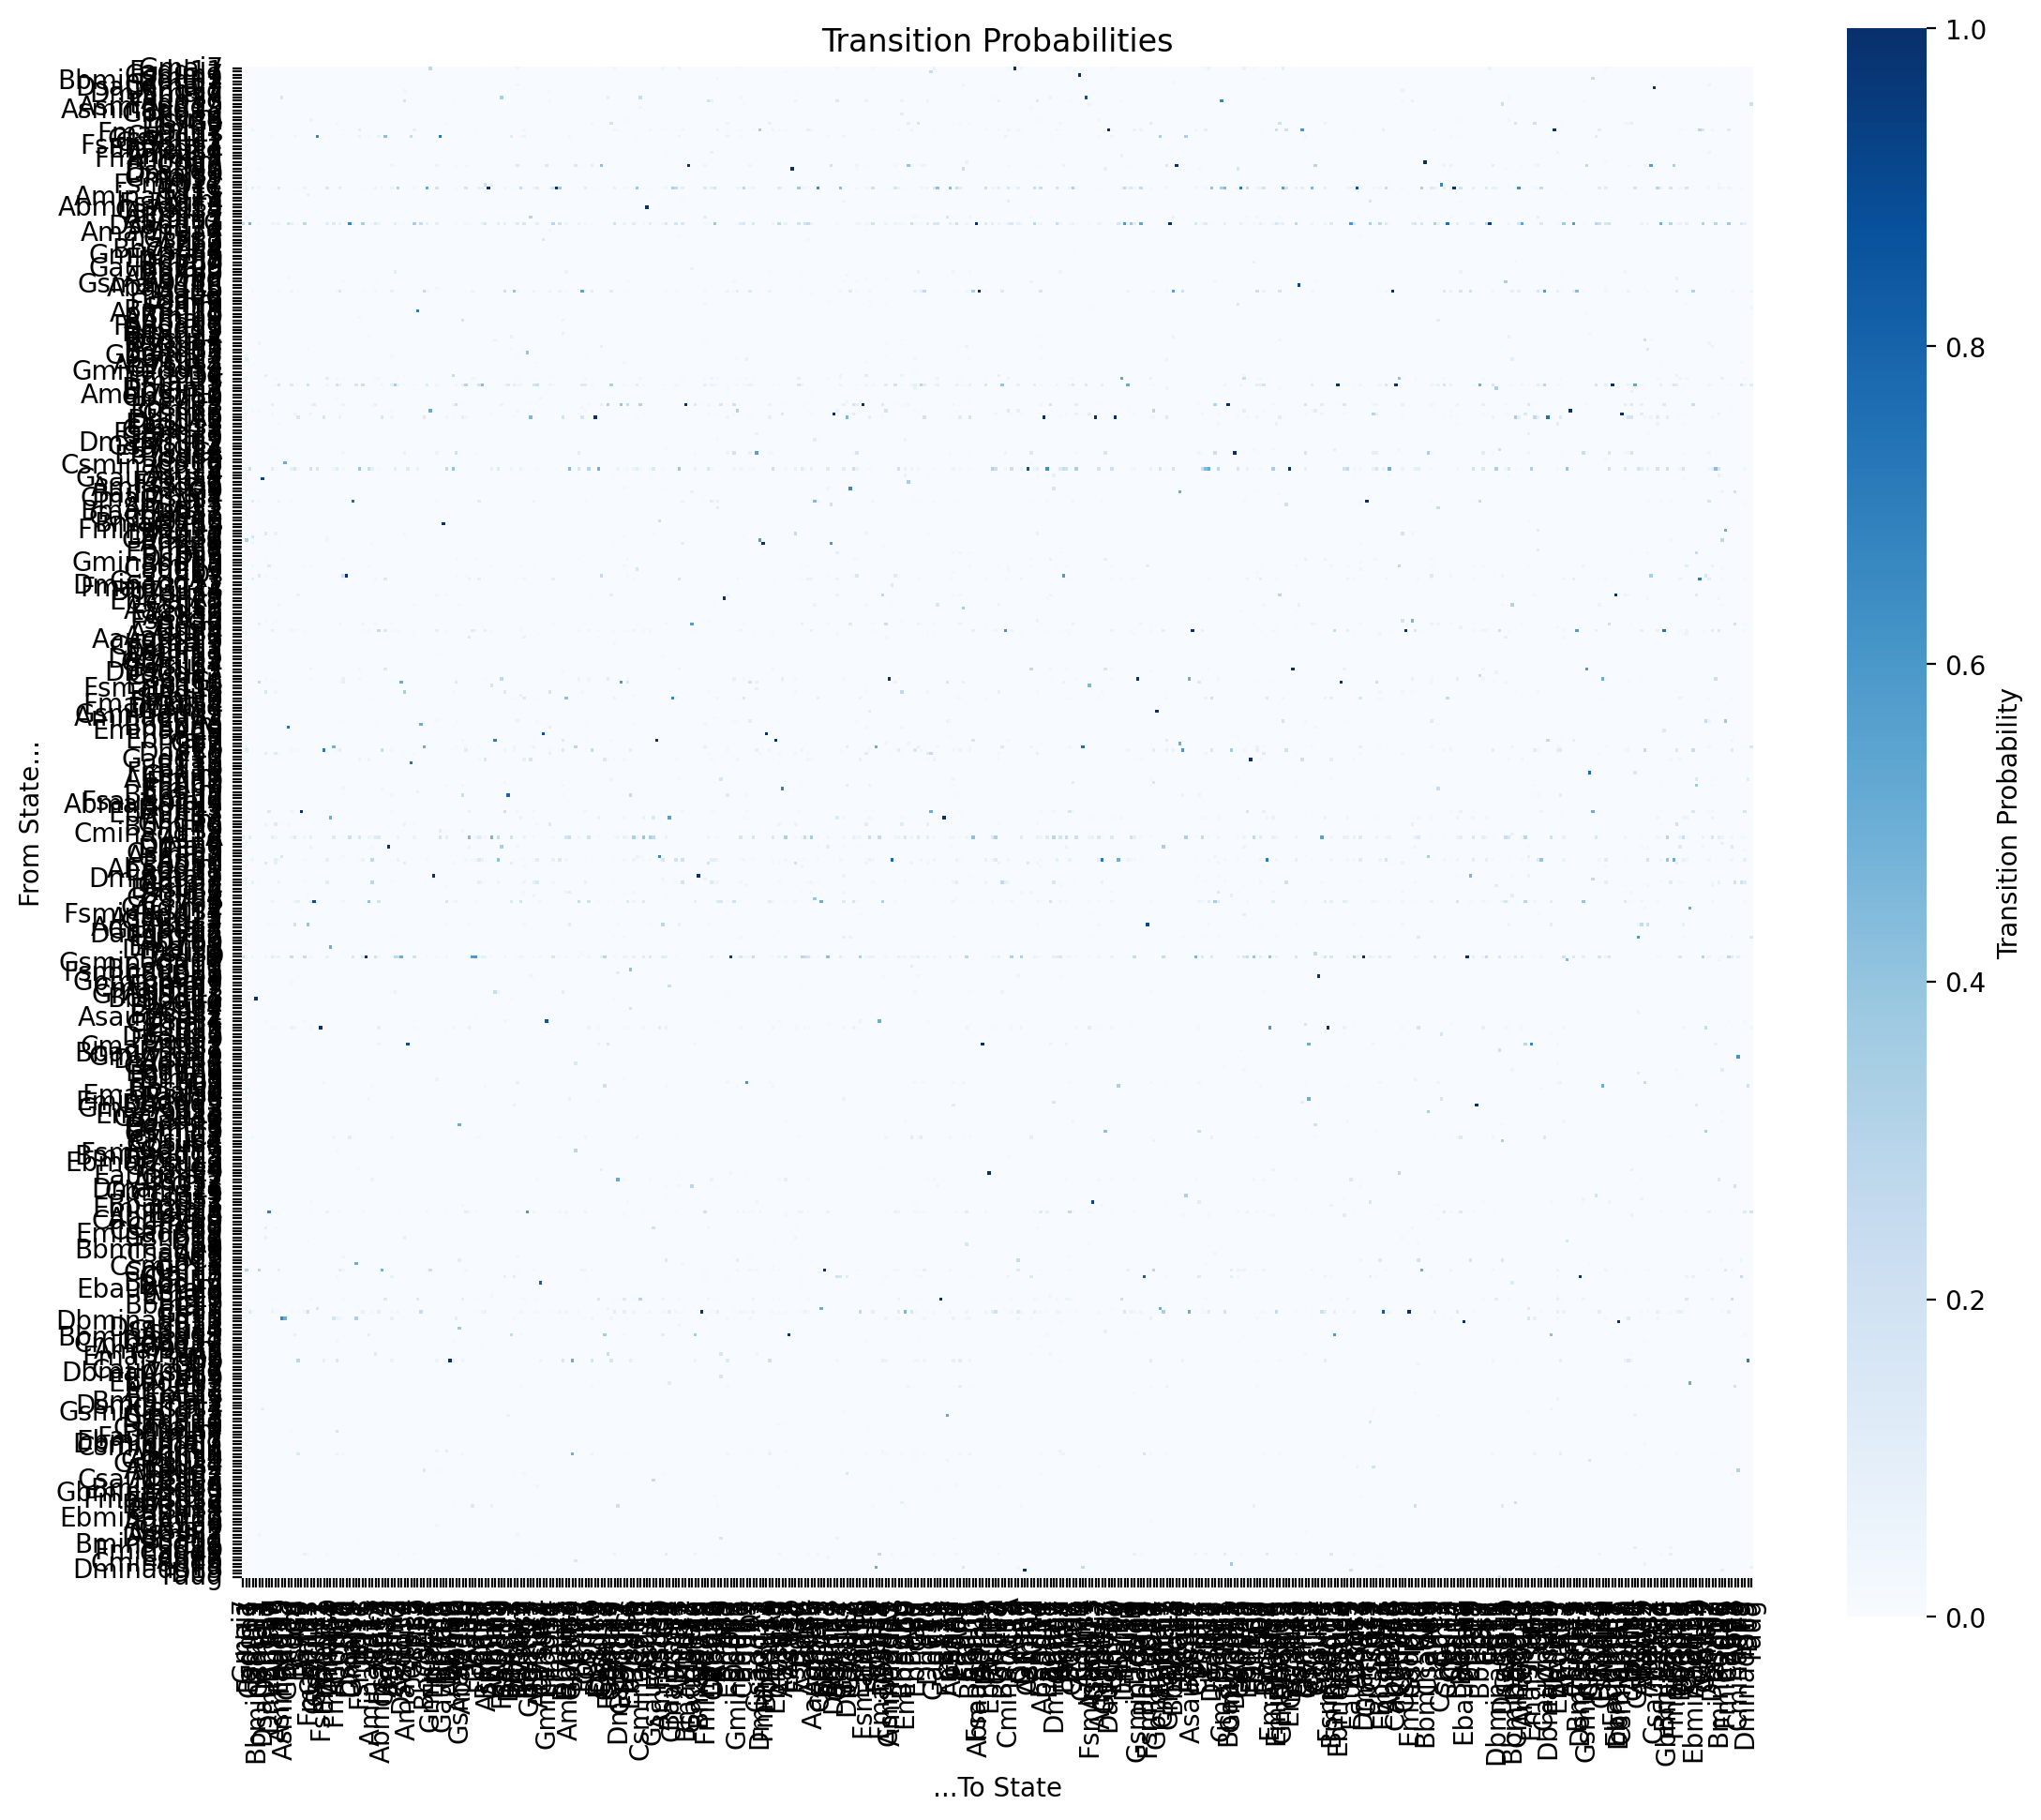

In [205]:
# Transition Probabilities Heatmap 
plt.figure(figsize=(13, 11))
sns.heatmap(tr_pr, 
            cmap='Blues',
            square=True,          
            xticklabels=states,
            yticklabels=states,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probabilities')
plt.xlabel('...To State')
plt.ylabel('From State...')
plt.show()

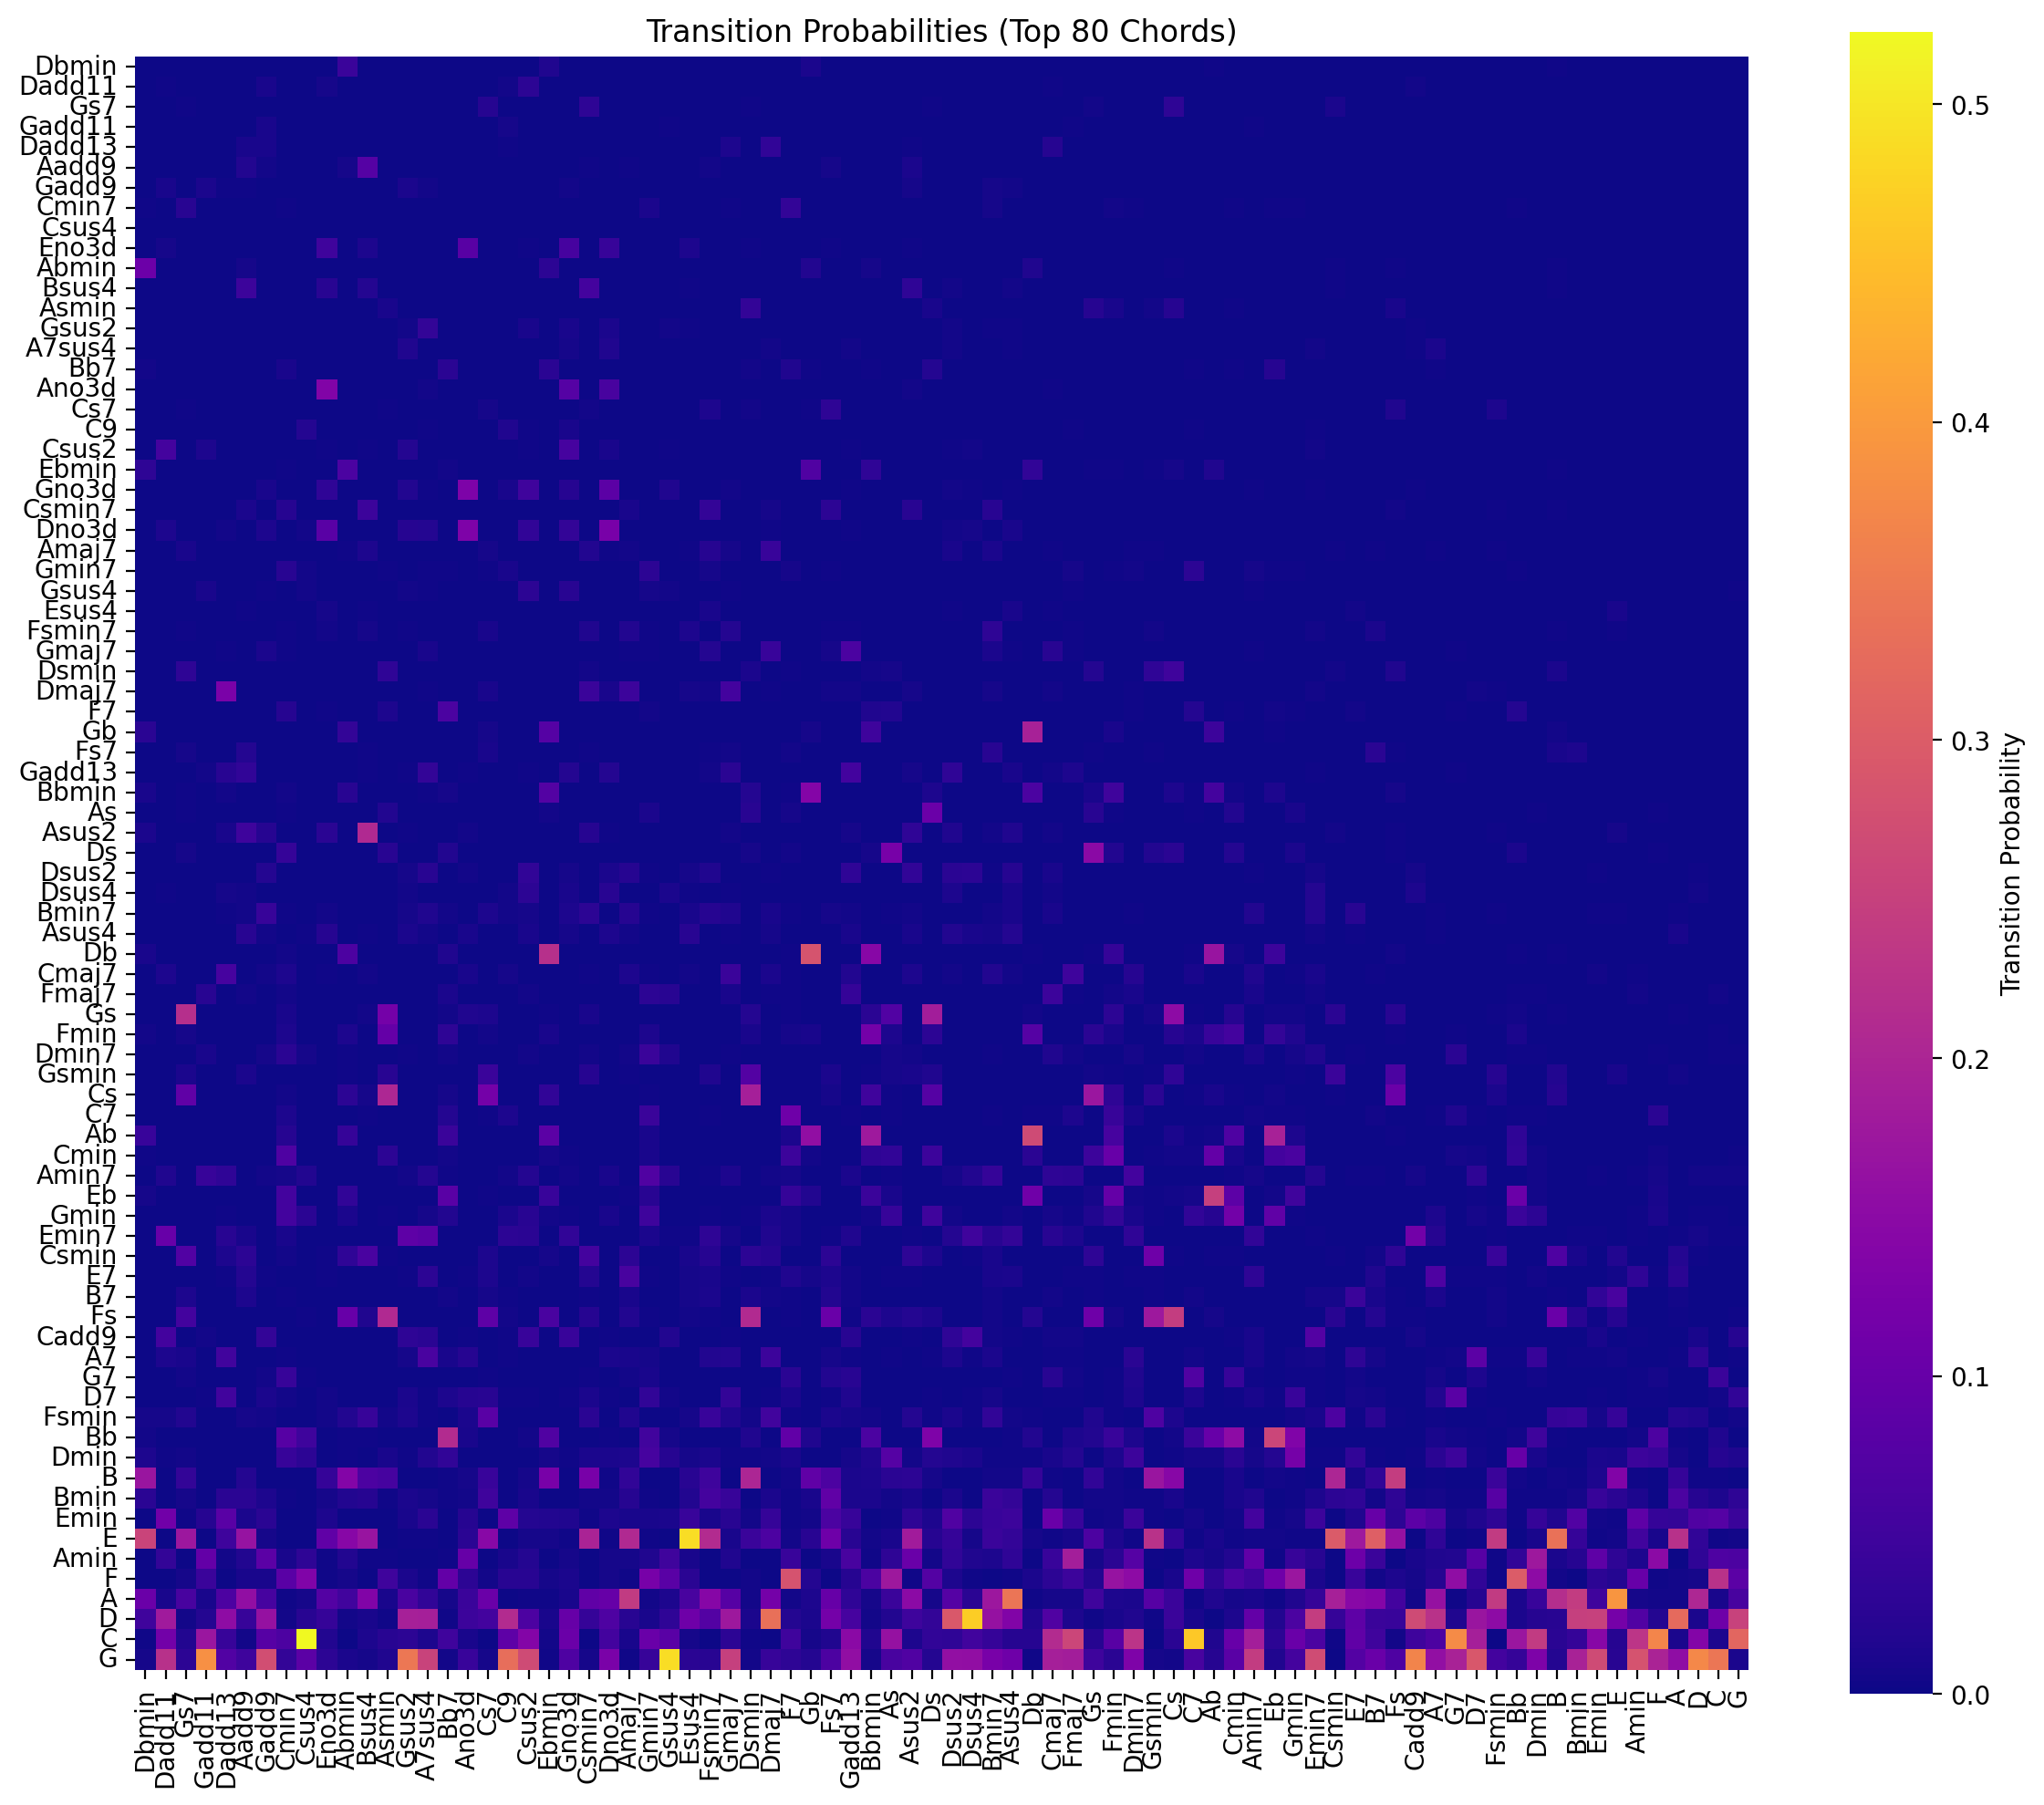

In [206]:
# Count how often each chord appears as "from" or "to"
chord_freq = tr_counts.sum(axis=0) + tr_counts.sum(axis=1)
top_n = 80  # can adjust this
top_indices = np.argsort(chord_freq)[-top_n:]

# Filter both rows and columns for top chords
tr_pr_top = tr_pr[np.ix_(top_indices, top_indices)]
top_states = [states[i] for i in top_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(
    tr_pr_top,
    cmap="plasma",
    square=True,
    xticklabels=top_states,
    yticklabels=top_states,
    cbar_kws={"label": "Transition Probability"}
)
plt.title(f"Transition Probabilities (Top {top_n} Chords)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


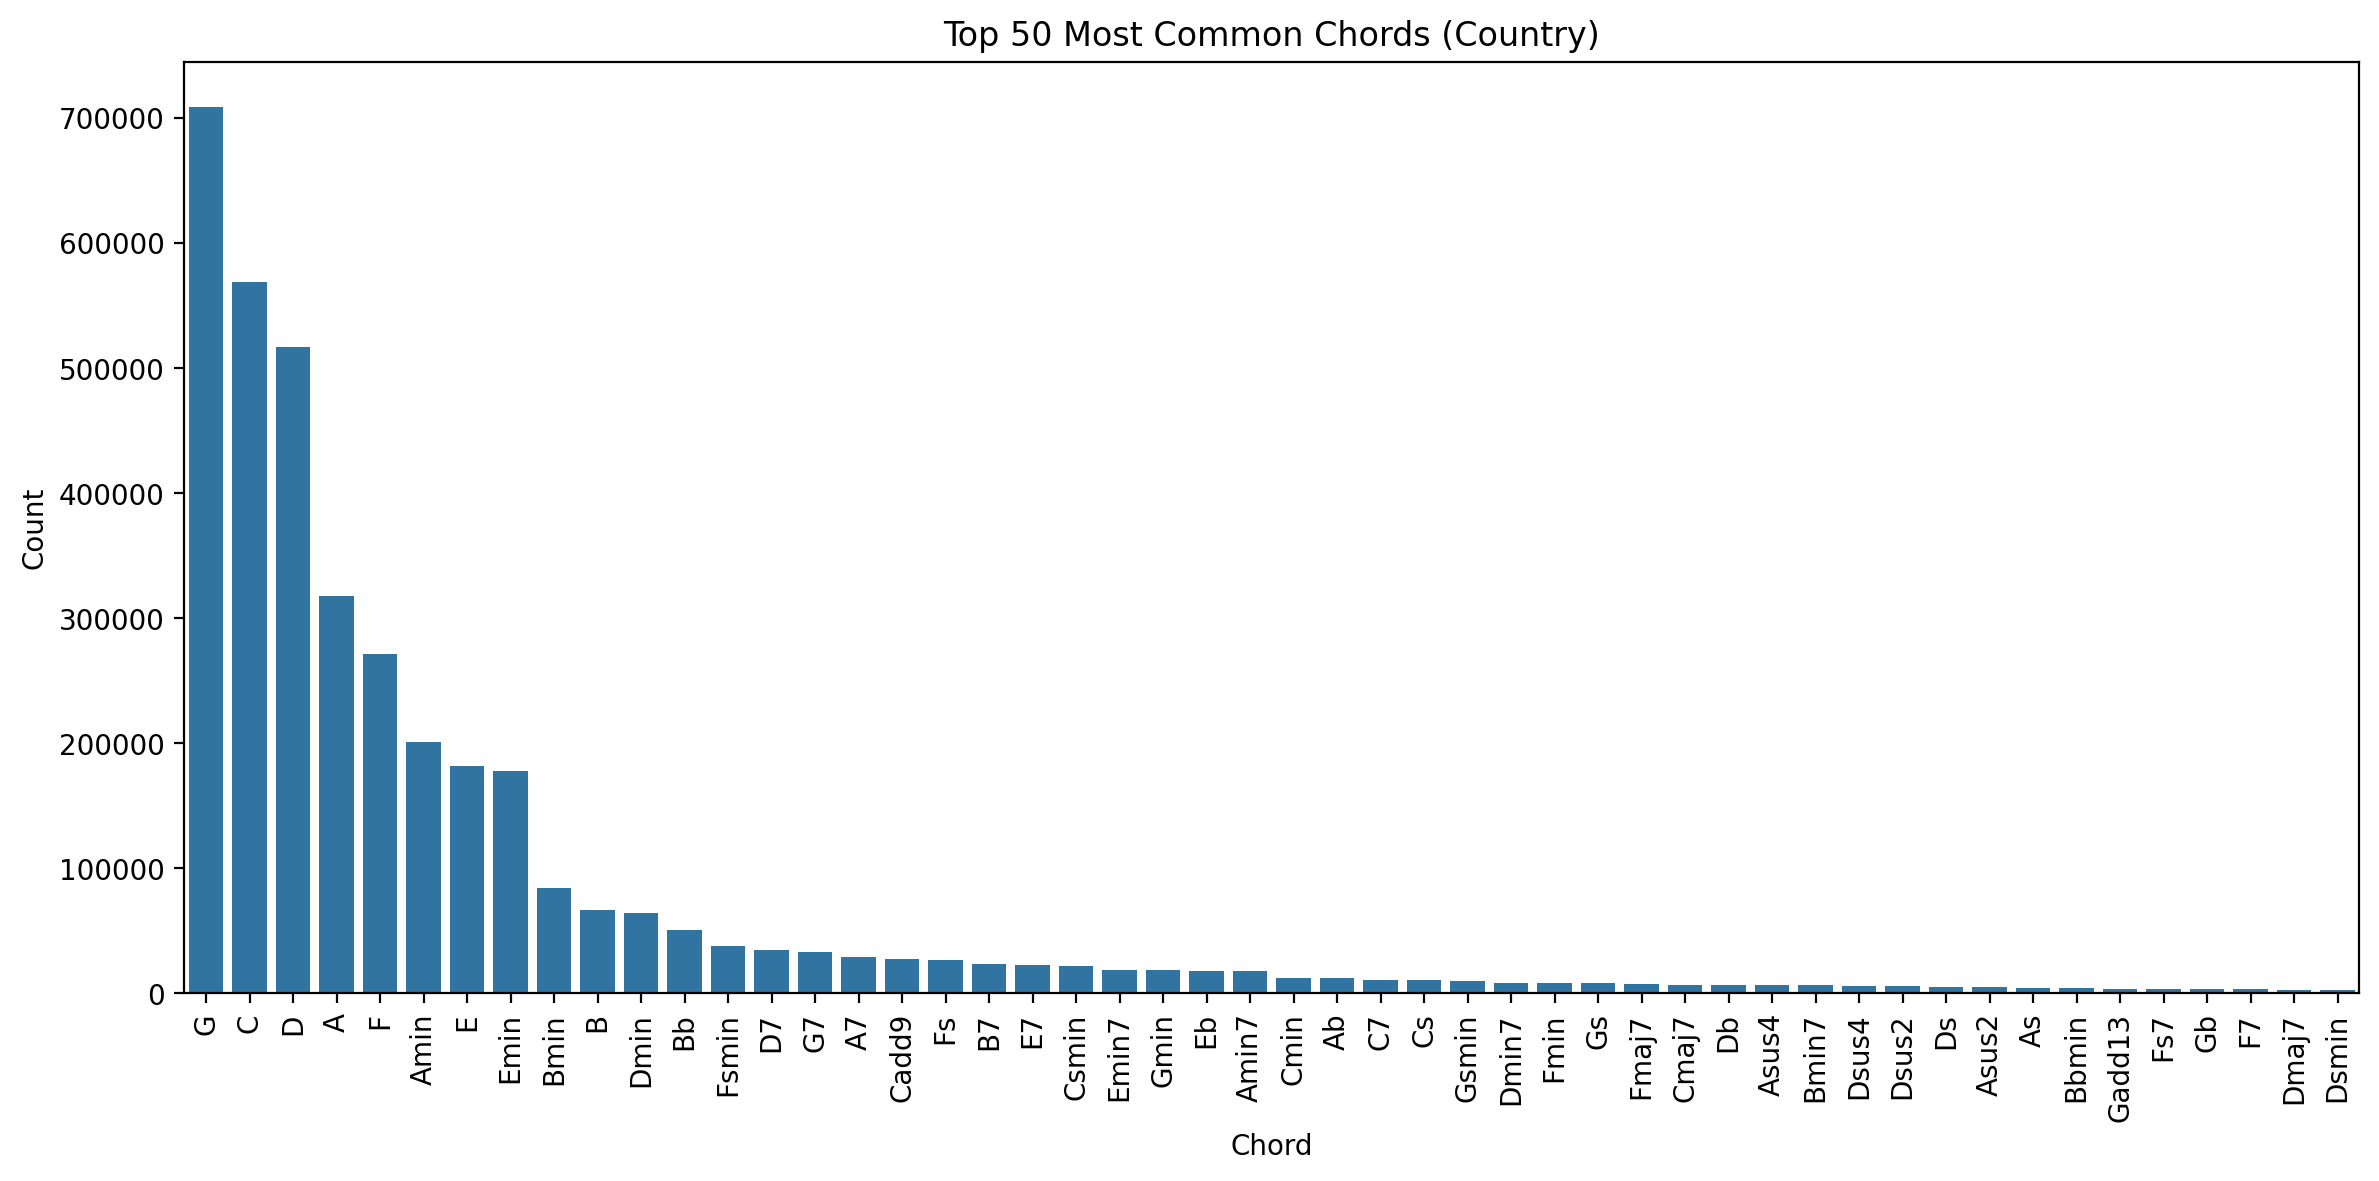

In [207]:
# Chord Histogram
## chord_lists is a list of lists where each inner list contains the chords for one song. To create a 
## histogram of chord frequencies, I need to flatten this nested list into a single list of all chords.
from collections import Counter

all_chords = [ch for song in chord_lists for ch in song]
chord_counts = Counter(all_chords)
chord_df = pd.DataFrame(chord_counts.items(), columns=['chord', 'count']).sort_values('count', ascending=False)

top_n = 50
top_chords = chord_df.head(top_n)

plt.figure(figsize=(12,6))
sns.barplot(data=top_chords, x="chord", y="count")
plt.xticks(rotation=90)
plt.title(f"Top {top_n} Most Common Chords (Country)")
plt.xlabel("Chord"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

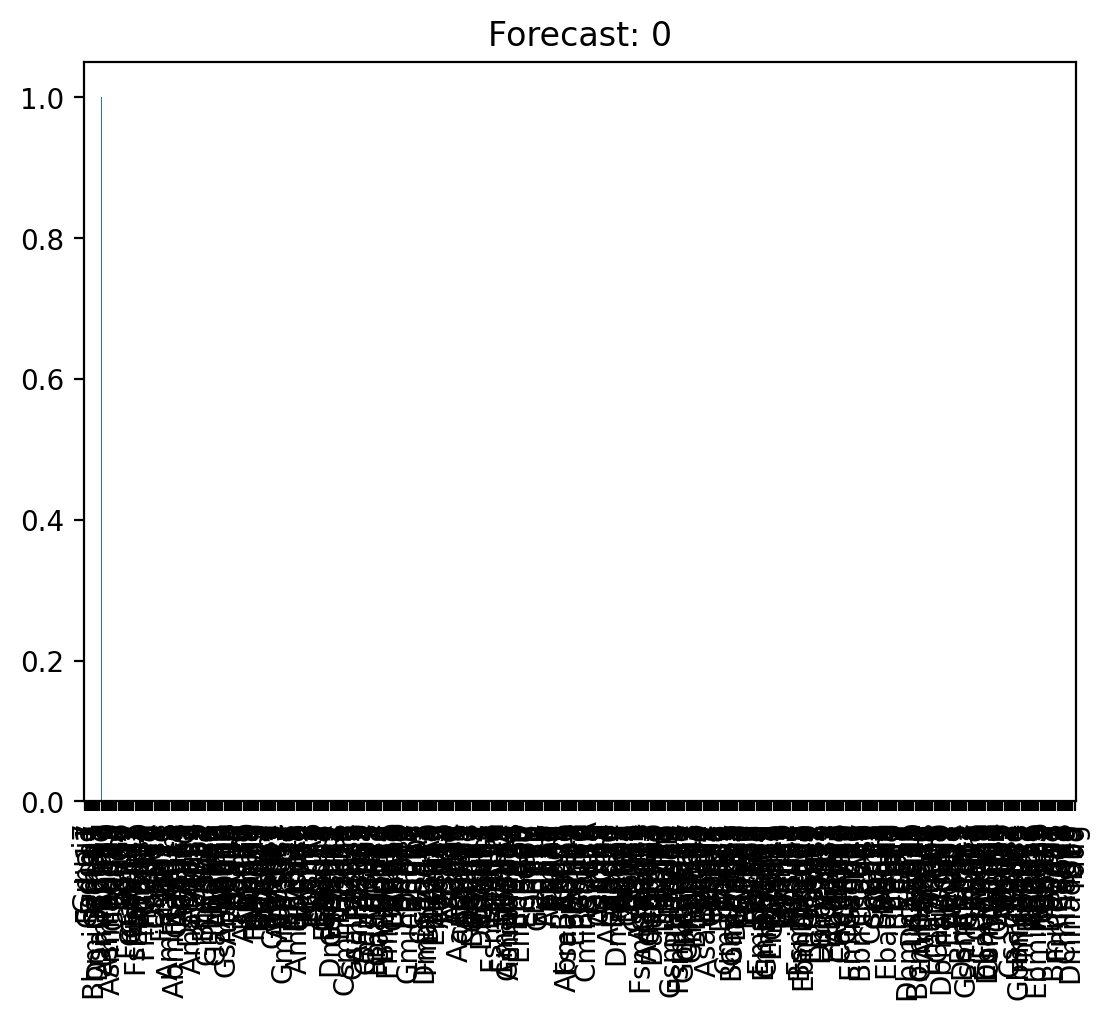

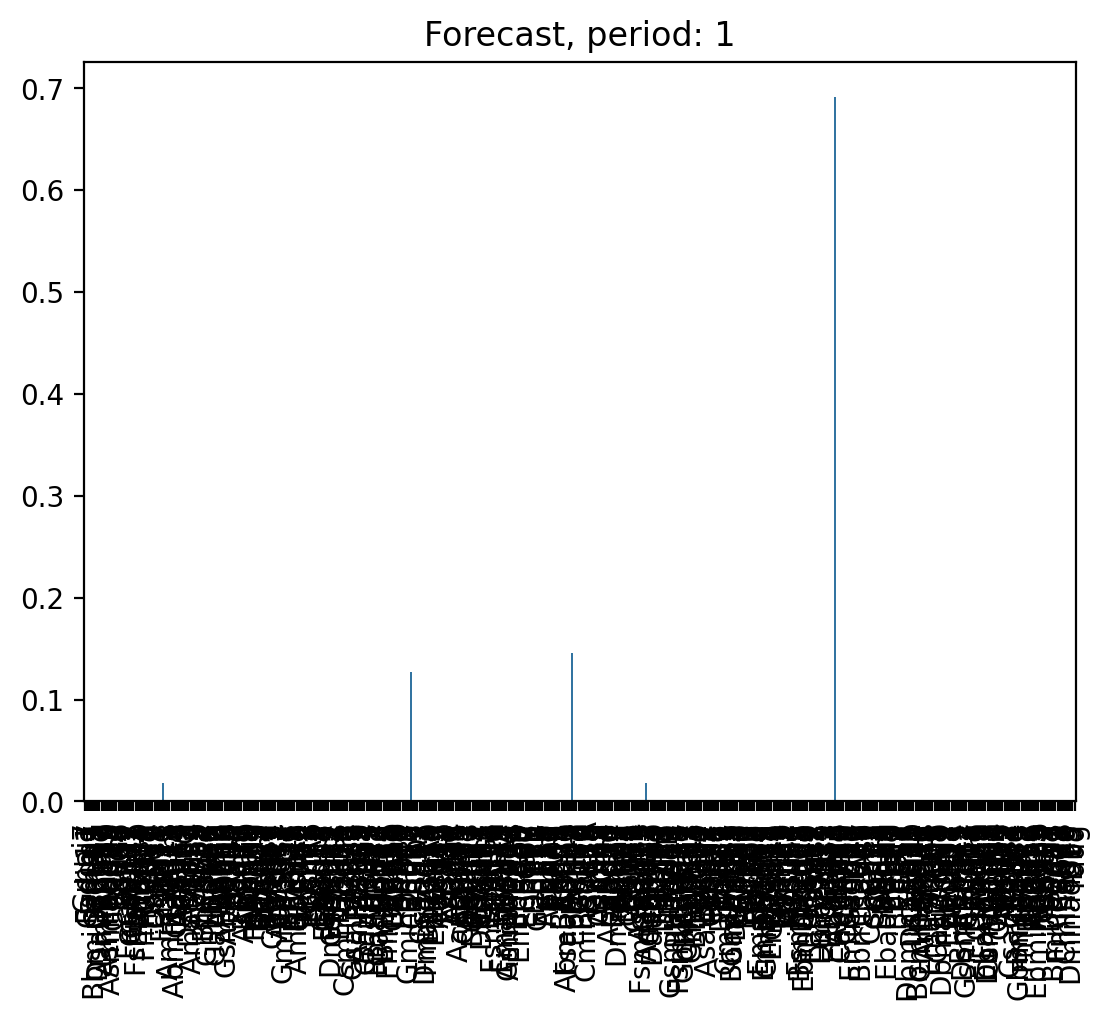

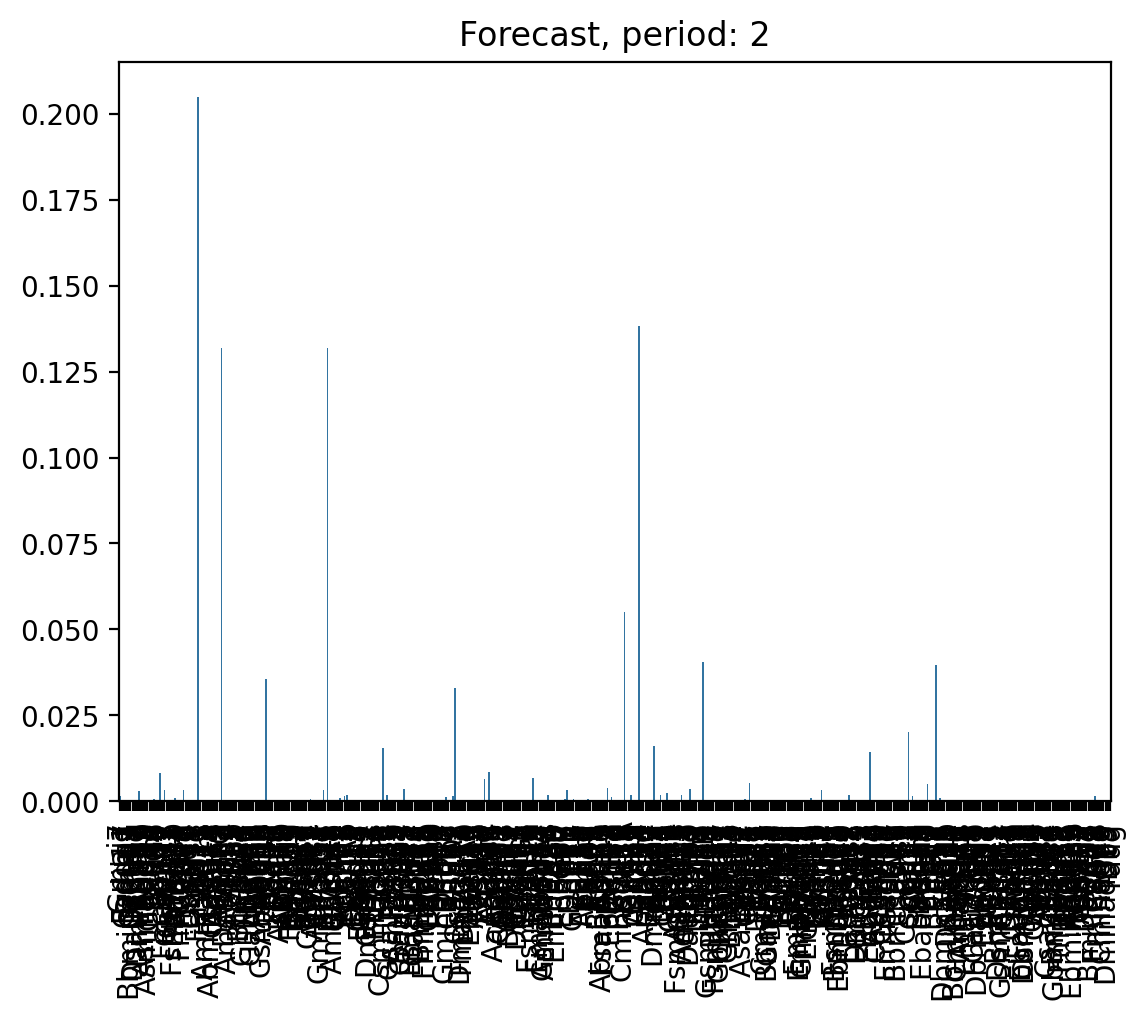

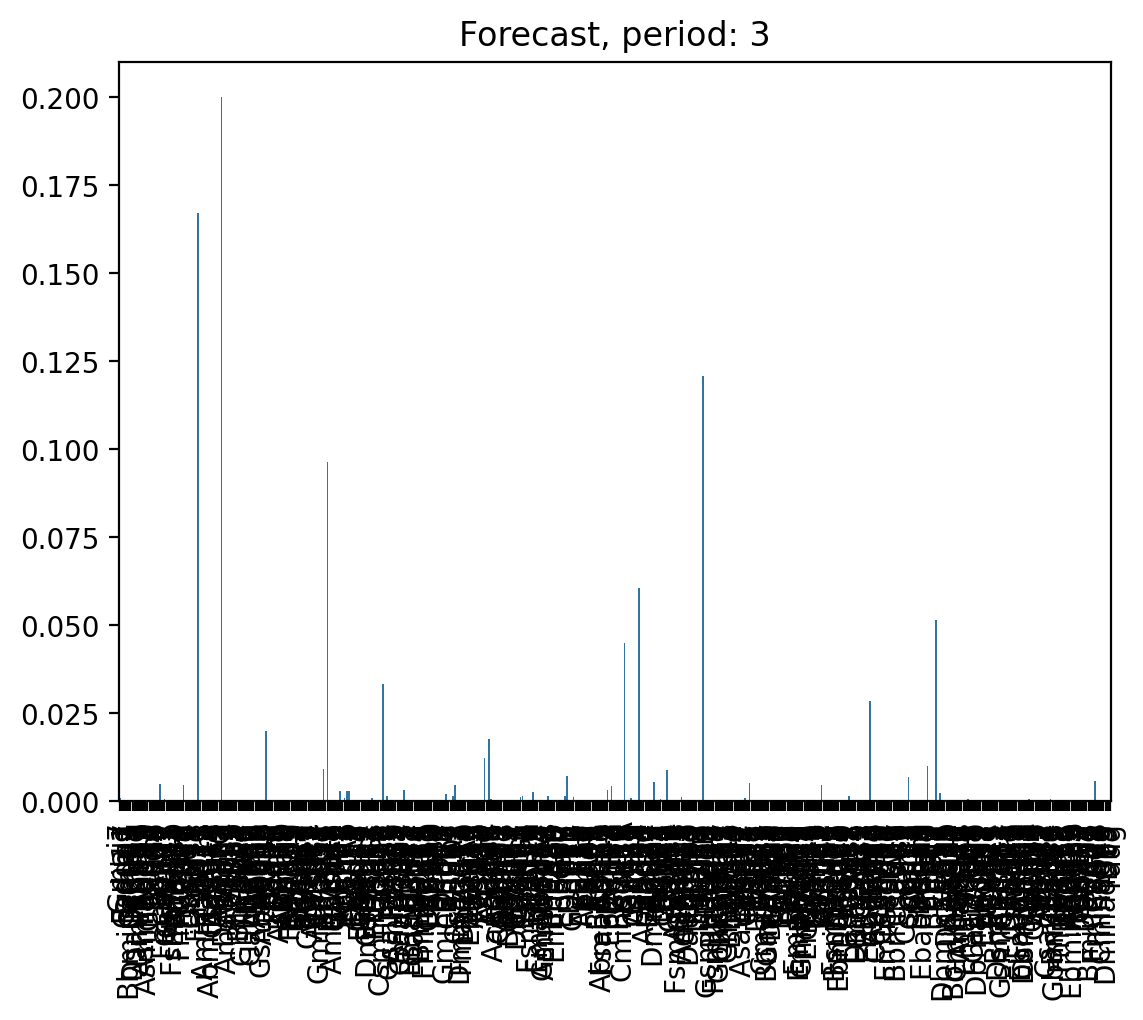

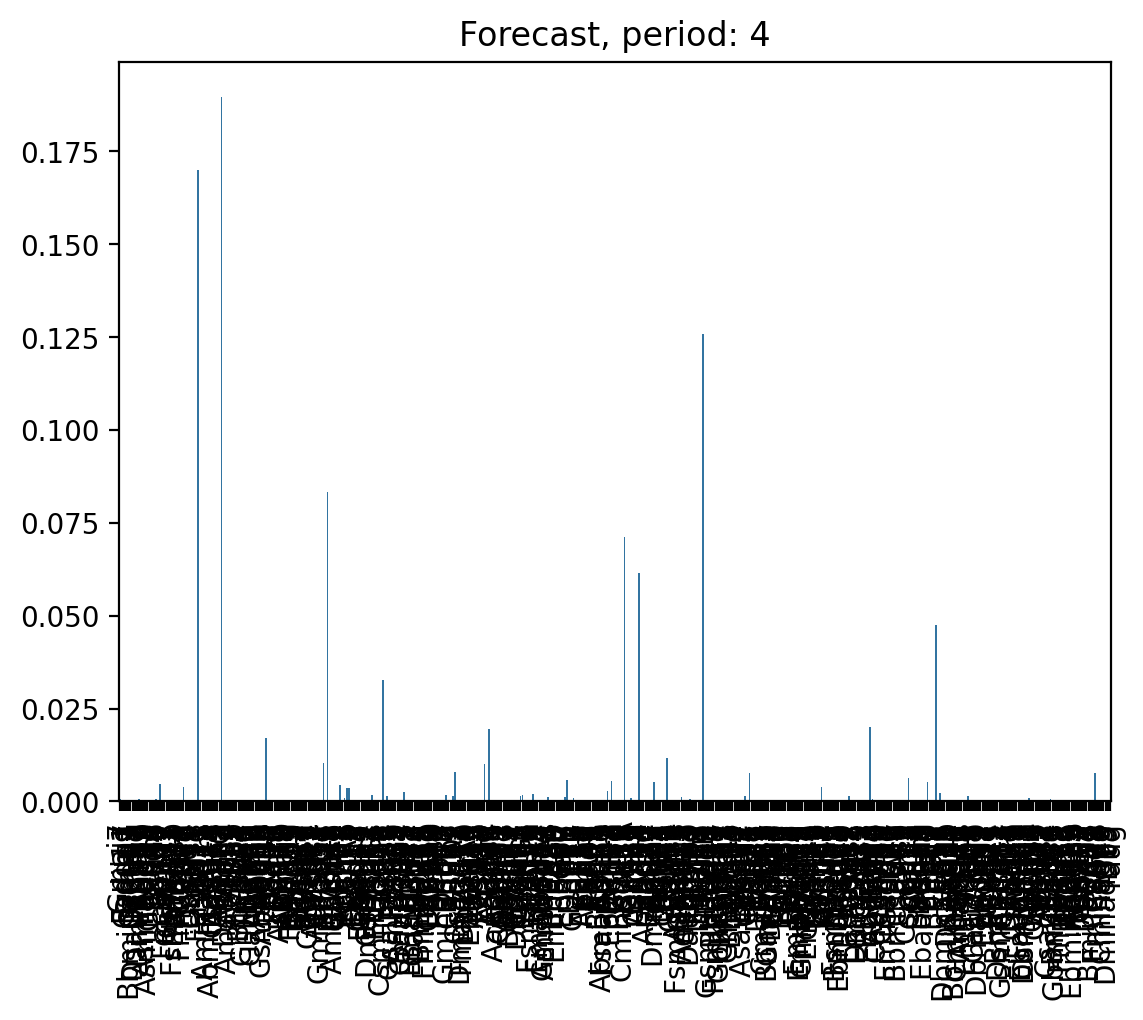

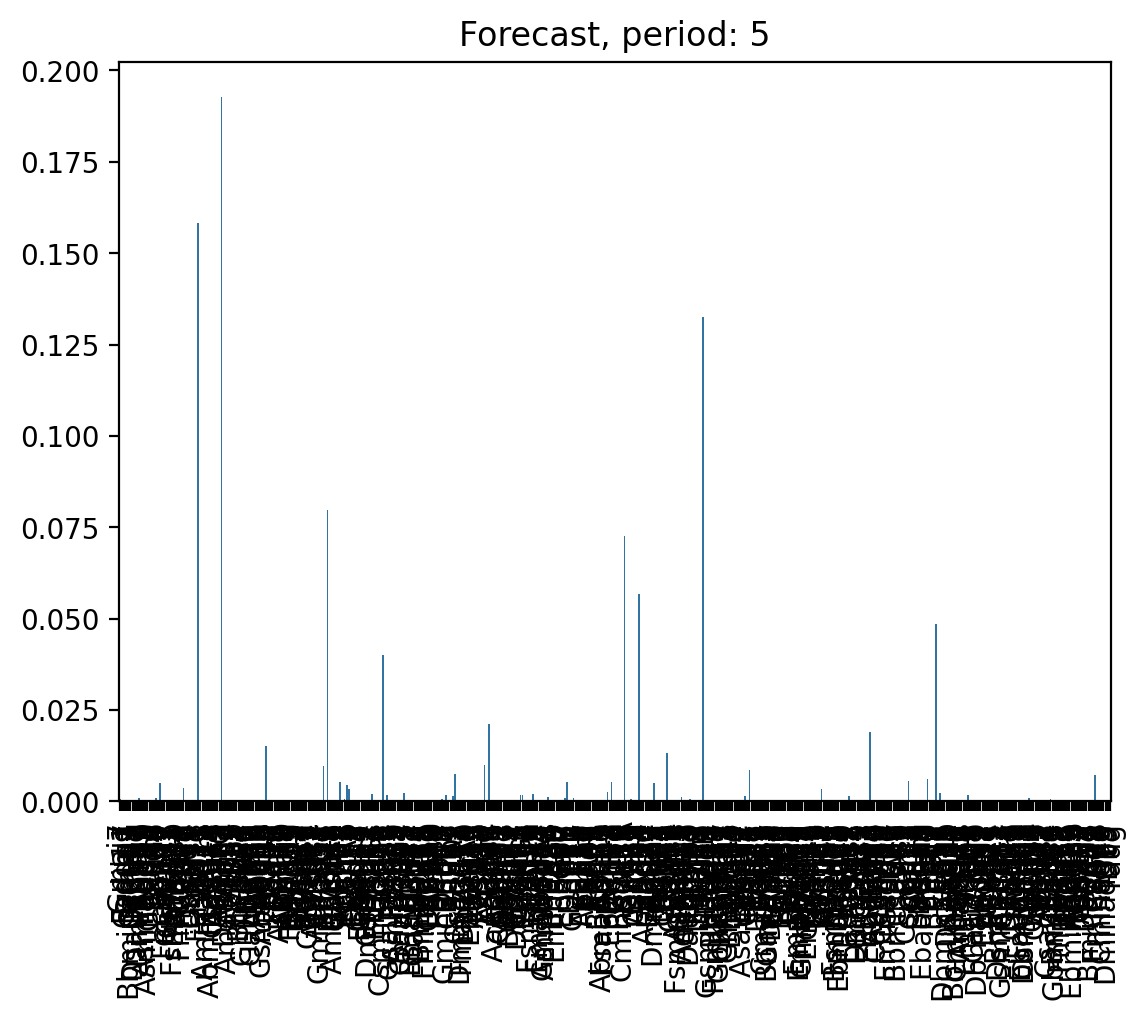

In [208]:
# Forecasting 
np.random.seed(100)

initial_state = np.random.choice(states) # Choose an initial state at random
state_index = states.index(initial_state) # Get the index of the initial state

# Initial density:
density = np.zeros(len(states))
density[state_index] = 1

sns.barplot(x=states,y=density).set(title=f'Forecast: 0')
plt.xticks(rotation=90)
plt.show()

n_sim = 5

forecast = [initial_state]
for t in range(n_sim): 
    density = tr_pr @ density
    forecast.append(density) # Append new forecast
    sns.barplot(x=states,y=density).set(title=f'Forecast, period: {str(t+1)}')
    plt.xticks(rotation=90)
    plt.show()

## Question 4

In [257]:
start = 'G'
sequence = [start]
sequence

for i in range(10):
    current_chord = sequence[-1]
    current_index = states.index(current_chord)
    
    probs = tr_pr[current_index]
    
    if probs.sum() == 0:
        break  
    next_chord = np.random.choice(states, p=probs/probs.sum())
    sequence.append(next_chord)

print("Generated chord sequence:")
print([str(chord) for chord in sequence])


Generated chord sequence:
['G', 'Gsus4', 'Fadd9', 'Ebadd9', 'Gmin7', 'Cmin7', 'Bbmin11', 'Eb7sus4', 'Eb7', 'Abmaj7', 'Bbmin9']


In [259]:
def aggressive_simplify(ch):
    
    ch = re.sub(r' ', '', ch)
    ch = re.sub(r'_', '', ch)
    ch = re.sub(r'M', '', ch)
    ch = re.sub(r'b', '-', ch)
    ch = re.sub(r'dim6', 'dim', ch)
    ch = re.sub(r'd', 'dim', ch)
    ch = re.sub(r'm4', 'm', ch)
    
    ch = re.sub(r'maj\d*', 'maj', ch)      # e.g., maj7, maj13 → maj
    ch = re.sub(r'majs', 'maj', ch)        # fix 'majs'
    ch = re.sub(r'smajs', 'maj', ch)       # fix 'smajs'
    ch = re.sub(r'smaj', 'maj', ch)        # fix 'Gsmaj'
    ch = re.sub(r'add\d+', '', ch)         # remove add11, add13
    ch = re.sub(r'sus\d+', 'sus4', ch)     # sus2/3 → sus4
    ch = re.sub(r'911s', '', ch)
    ch = re.sub(r'sadim', 'dim', ch)
    ch = re.sub(r'dimdim', 'dim', ch)      # collapse double dim
    ch = re.sub(r'-', '', ch)
    
    ch = ch.replace('Gs', 'G#')
    
    return ch

simplified_sequence = [aggressive_simplify(ch) for ch in sequence]

stream = music21.stream.Stream()
for chord_symbol in simplified_sequence:
    try:
        chord = music21.harmony.ChordSymbol(chord_symbol)
        chord.duration = music21.duration.Duration(2.0)
        stream.append(chord)
    except ValueError:
        print(f"Skipping invalid chord even after aggressive simplification: {chord_symbol}")
        continue

stream.show('midi')


Skipping invalid chord even after aggressive simplification: G#us4
Skipping invalid chord even after aggressive simplification: Fadim9
Skipping invalid chord even after aggressive simplification: Eadim9
